# Endpoint Deployment and AWS Lambda Code

In [2]:
import boto3
import base64
import json
import random
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg
import os
import glob
import sagemaker
from sagemaker import get_execution_role
from sagemaker import image_uris

from datetime import datetime
import pytz

berlin_timezone = pytz.timezone('Europe/Berlin')

from utils.model_inference import predict_and_show
import importlib
import utils.model_inference

#importlib.reload(utils.model_inference)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [3]:
# SDK
s3 = boto3.resource('s3', region_name='us-east-2')
role = get_execution_role()
session = sagemaker.Session()

# Time variable 
current_berlin_time = datetime.now(berlin_timezone)
formatted_time = current_berlin_time.strftime('%d-%m-%Y %H:%M:%S')


runtime = boto3.client(service_name = "runtime.sagemaker")

# Model artifact
best_model = "s3://airplane-object-detection-project/model/model_output/object-detection-231007-1859-004-ce692836/output/model.tar.gz"


# Retrieving the image
training_image = image_uris.retrieve(region = session.boto_region_name, 
                                     framework = "object-detection", 
                                     version = "1")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [5]:
# Deploying model
model = sagemaker.model.Model(
    image_uri = training_image,
    model_data = best_model,
    role = role) 

endpoint_name = f"airplane-detection-endpoint-inference"

deploy_model = model.deploy(
    initial_instance_count = 1,
    instance_type = "ml.m4.xlarge",
    endpoint_name = endpoint_name)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
--------------!

## Test Model Endpoint and Visualize Images

In [13]:
def draw_bounding_boxes_local(image_file, detections, threshold=0.6):
    image = mpimg.imread(image_file)
    plt.imshow(image)
    
    image_height, image_width = image.shape[:2]
    assigned_colors = dict()
    detected_count = 0
    
    for detection in detections:
        klass, score, x0, y0, x1, y1 = detection
        if score < threshold:
            continue
        
        detected_count += 1
        class_id = int(klass)
        
        if class_id not in assigned_colors:
            assigned_colors[class_id] = random.random(), random.random(), random.random()
            
        xmin = int(x0 * image_width)
        ymin = int(y0 * image_height)
        xmax = int(x1 * image_width)
        ymax = int(y1 * image_height)
        
        bounding_box = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor=assigned_colors[class_id],
            linewidth=2.5
        )
        
        plt.gca().add_patch(bounding_box)
        plt.gca().text(
            xmin,
            ymin - 2,
            "{:.3f}".format(score),
            bbox=dict(facecolor=(1, 0, 0, 1), alpha=0.5),
            color="white"
        )
    if detected_count > 1:
        print(f"Model detected {detected_count}  airplane - Threshold: {threshold}")
        
    elif detected_count == 0:

        print(f"{detected_count} airplane detected - Threshold: {threshold}")
        
    else:
        print(f"Model detected only {detected_count} airplane - Threshold: {threshold}")
        
    plt.show()


def predict_and_show_local(image_filename, endpoint_name, runtime, threshold=0.3):
    with open(image_filename, "rb") as image_file:
        encoded_image = bytearray(image_file.read())
        
        
    response = runtime.invoke_endpoint(
        EndpointName=endpoint_name, 
        ContentType="image/jpeg", 
        Body=encoded_image
    )
    
    results = json.loads(response["Body"].read())
    
    draw_bounding_boxes_local(image_filename, results["prediction"], threshold)

Model detected only 1 airplane - Threshold: 0.3


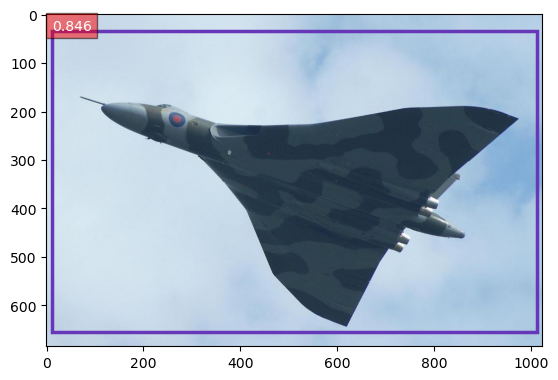

In [8]:
predict_and_show_local("data/airplane_validation/airplane1.jpg", endpoint_name, runtime)

Model detected only 1 airplane - Threshold: 0.3


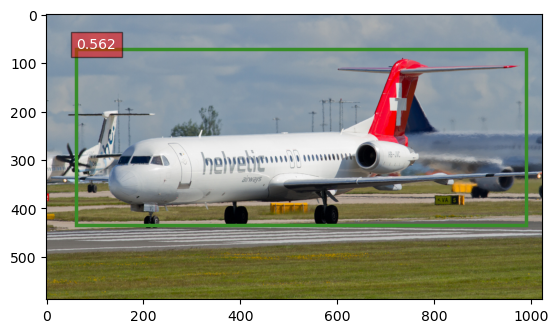

In [9]:
predict_and_show_local("data/airplane_validation/airplane2.jpg", endpoint_name, runtime)

Model detected only 1 airplane - Threshold: 0.3


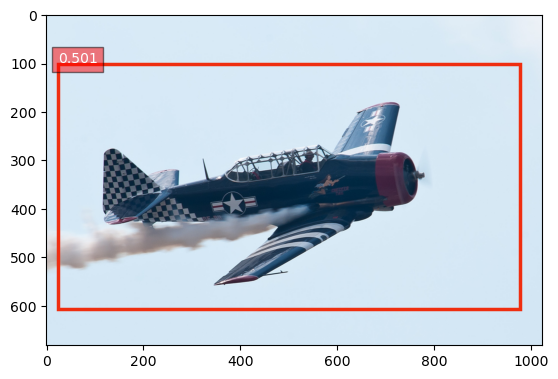

In [10]:
predict_and_show_local("data/airplane_validation/airplane3.jpg", endpoint_name, runtime)

Model detected 4  airplane - Threshold: 0.3


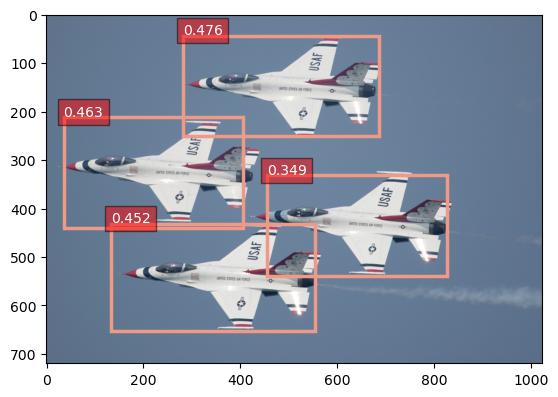

In [12]:
predict_and_show_local("data/airplane_validation/airplane4.jpg", endpoint_name, runtime)

## Lambda Function

In [ ]:
import json
import boto3
import base64
import os

# Environment variables
endpoint_name = os.enviro["ENDPOINT_NAME"] 
runtime = boto3.client("runtime.sagemaker")

def lambda_handler(event, context):
    
    # Get the encoded image
    encoded_image_data = event["image"]
    
    decoded_image = base64.b64decode(encoded_image_data)
    
    image_byte_array = bytearray(decoded_image)

    # Get model detections passing the endode image
    detections = get_detections(image_byte_array)
    
    return {
        'statusCode': 200,
        'body': json.dumps({
            'detections': detections
        })
    }

def get_detections(image):
    response = runtime.invoke_endpoint(
        EndpointName=endpoint_name, 
        ContentType="image/jpeg", 
        Body=image
    )
    
    results = json.loads(response["Body"].read())
    detections = results["prediction"]
    
    return detections